In [158]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import time

In [159]:
base_url = "https://api.magicthegathering.io/v1/cards"

In [160]:
endpoint = "?set=LTR"
url = base_url + endpoint

In [161]:
all_cards = []
page = 1

while True:
    response = requests.get(url, params={"page": page})
    data = response.json().get("cards", [])
    
    if not data:  # Stop when no cards are returned
        break
    
    all_cards.extend(data)
    print(f"Fetched page {page} with {len(data)} cards")
    page += 1
    time.sleep(1)


Fetched page 1 with 100 cards
Fetched page 2 with 100 cards
Fetched page 3 with 100 cards
Fetched page 4 with 100 cards
Fetched page 5 with 100 cards
Fetched page 6 with 100 cards
Fetched page 7 with 100 cards
Fetched page 8 with 100 cards
Fetched page 9 with 56 cards


In [162]:
data = pd.json_normalize(all_cards)
print(f"Total cards: {len(data)}")


trimmed_data = data[['number', 'name', 'manaCost', 'cmc', 'colors', 'colorIdentity', 'types', 
                    'supertypes', 'subtypes', 'rarity', 'set', 'setName', 'power', 
                    'toughness', 'multiverseid', 'id']]

trimmed_data = trimmed_data[trimmed_data['multiverseid'].notna()]
trimmed_data['multiverseid'] = trimmed_data['multiverseid'].astype(int)

formatted_data = trimmed_data.loc[trimmed_data.groupby('name')['multiverseid'].idxmin()]

formatted_data['mana_generic'] = formatted_data['manaCost'].str.extract(r'(\{[\dX]\})')
formatted_data['mana_generic'] = formatted_data['mana_generic'].str.replace(r'[{}]', "", regex = True)
formatted_data['mana_generic'] = formatted_data['mana_generic'].fillna(0)


formatted_data['mana_colored'] = (formatted_data['manaCost'].str.extractall(r'\{([WUBRG])\}').groupby(level=0)[0].apply(list))
formatted_data['mana_colored'] = formatted_data['mana_colored'].apply(lambda x: x if isinstance(x, list) else ['None'])

formatted_data['colorIdentity'] = formatted_data['colorIdentity'].fillna('None')


formatted_data = formatted_data[['number', 'name', 'mana_generic', 'mana_colored', 'cmc', 'colors', 'colorIdentity', 'types', 
                    'supertypes', 'subtypes', 'rarity', 'set', 'setName', 'power', 
                    'toughness', 'multiverseid', 'id']]


Total cards: 856


<Axes: xlabel='colorIdentity', ylabel='cmc'>

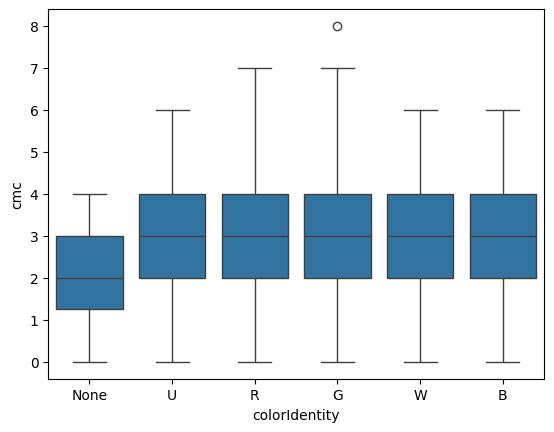

In [175]:
plot_df = formatted_data.copy()
# keep only rows where colorIdentity is a list of length 1
plot_df = plot_df[plot_df['colorIdentity'].apply(lambda x: (isinstance(x, list) and len(x) <= 1) or x == 'None')]
# convert single-element lists to the element (e.g. ['W'] -> 'W')
plot_df['colorIdentity'] = plot_df['colorIdentity'].apply(lambda x: x[0] if isinstance(x, list) else x)


sns.boxplot(data=plot_df, x='colorIdentity', y='cmc')

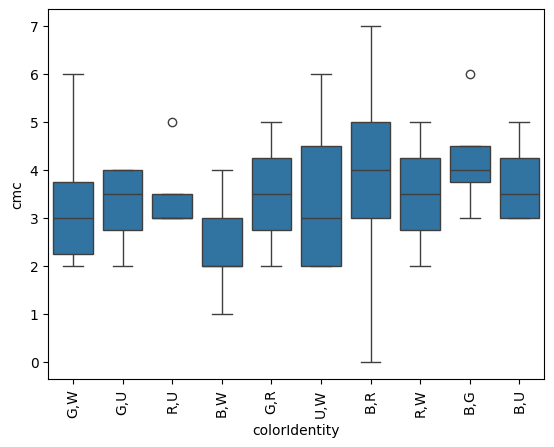

In [176]:
plot_df = formatted_data.copy()
# keep only rows where colorIdentity is a list of length > 1
plot_df = plot_df[plot_df['colorIdentity'].apply(lambda x: isinstance(x, list) and (len(x) > 1 and len(x) < 3))]
# convert lists to string (e.g. ['G', 'W'] -> 'G,W')
plot_df['colorIdentity'] = plot_df['colorIdentity'].apply(lambda x: ",".join(x) if isinstance(x, list) else str(x))


sns.boxplot(data=plot_df, x='colorIdentity', y='cmc')
plt.xticks(rotation = 90)
plt.show()

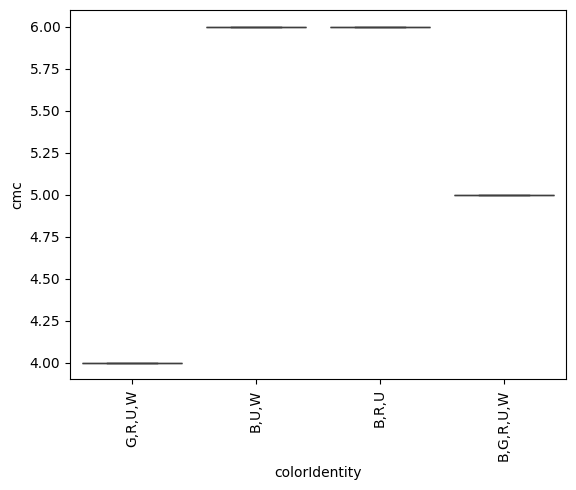

In [177]:
plot_df = formatted_data.copy()
# keep only rows where colorIdentity is a list of length > 1
plot_df = plot_df[plot_df['colorIdentity'].apply(lambda x: isinstance(x, list) and len(x) > 2)]
# convert lists to string (e.g. ['G', 'W'] -> 'G,W')
plot_df['colorIdentity'] = plot_df['colorIdentity'].apply(lambda x: ",".join(x) if isinstance(x, list) else str(x))


sns.boxplot(data=plot_df, x='colorIdentity', y='cmc')
plt.xticks(rotation = 90)
plt.show()

In [166]:
formatted_data['colorIdentity'].value_counts()

colorIdentity
[W]                44
[B]                44
[R]                44
[G]                43
[U]                42
None               22
[B, R]              7
[G, W]              6
[B, W]              5
[G, U]              4
[G, R]              4
[R, U]              4
[B, U]              4
[U, W]              4
[R, W]              4
[B, G]              4
[G, R, U, W]        1
[B, U, W]           1
[B, R, U]           1
[B, G, R, U, W]     1
Name: count, dtype: int64

<Axes: xlabel='rarity', ylabel='cmc'>

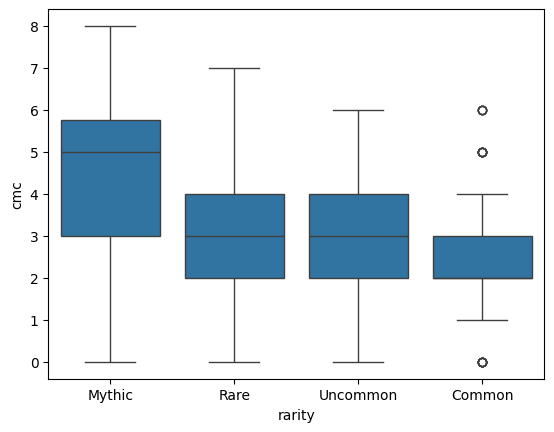

In [167]:
sns.boxplot(data = formatted_data, x = 'rarity', y = 'cmc')

In [168]:
formatted_data['rarity'].value_counts()

rarity
Common      108
Uncommon     80
Rare         79
Mythic       22
Name: count, dtype: int64

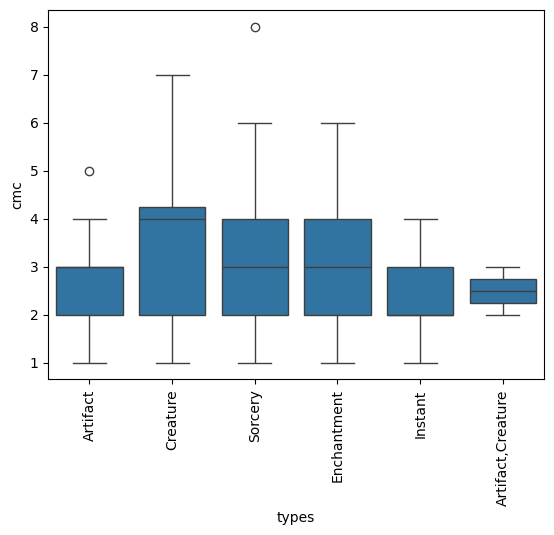

In [173]:
plot_df = formatted_data.copy()
# keep only rows where colorIdentity is a list of length > 1
plot_df = plot_df[plot_df['types'].apply(lambda x: isinstance(x, list) and x != ['Land'])]
# convert lists to string (e.g. ['G', 'W'] -> 'G,W')
plot_df['types'] = plot_df['types'].apply(lambda x: ",".join(x) if isinstance(x, list) else str(x))


sns.boxplot(data=plot_df, x='types', y='cmc')
plt.xticks(rotation = 90)
plt.show()

In [170]:
formatted_data['types'].value_counts()

types
[Creature]              148
[Instant]                38
[Sorcery]                36
[Enchantment]            28
[Artifact]               23
[Land]                   14
[Artifact, Creature]      2
Name: count, dtype: int64

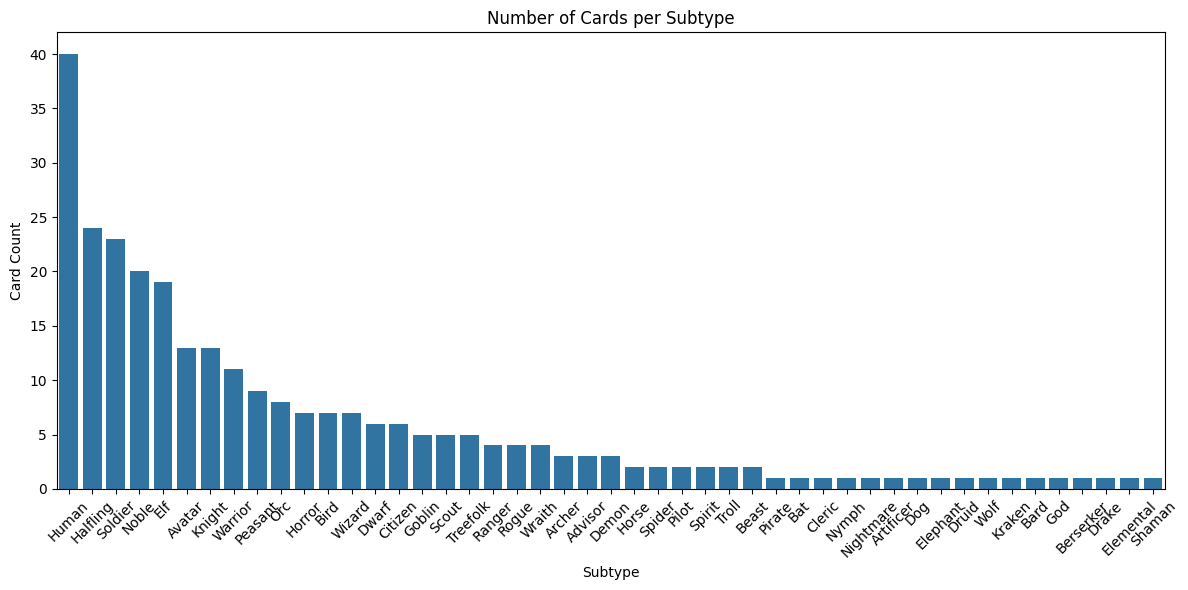

In [189]:
plot_df = formatted_data.copy()

plot_df = plot_df[plot_df['types'].apply(lambda x: isinstance(x, list) and (x == ['Creature'] or x == ['Artifact, Creature']) )]
plot_df['subtypes'] = plot_df['subtypes'].apply(lambda x: x if isinstance(x, list) else [])

# Step 2: Explode the list into multiple rows
plot_df = plot_df.explode('subtypes').reset_index(drop=True)


subtype_counts = plot_df['subtypes'].value_counts().reset_index()
subtype_counts.columns = ['subtype', 'count']

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=subtype_counts, x='subtype', y='count')
plt.xticks(rotation=45)
plt.title('Number of Cards per Subtype')
plt.ylabel('Card Count')
plt.xlabel('Subtype')
plt.tight_layout()
plt.show()


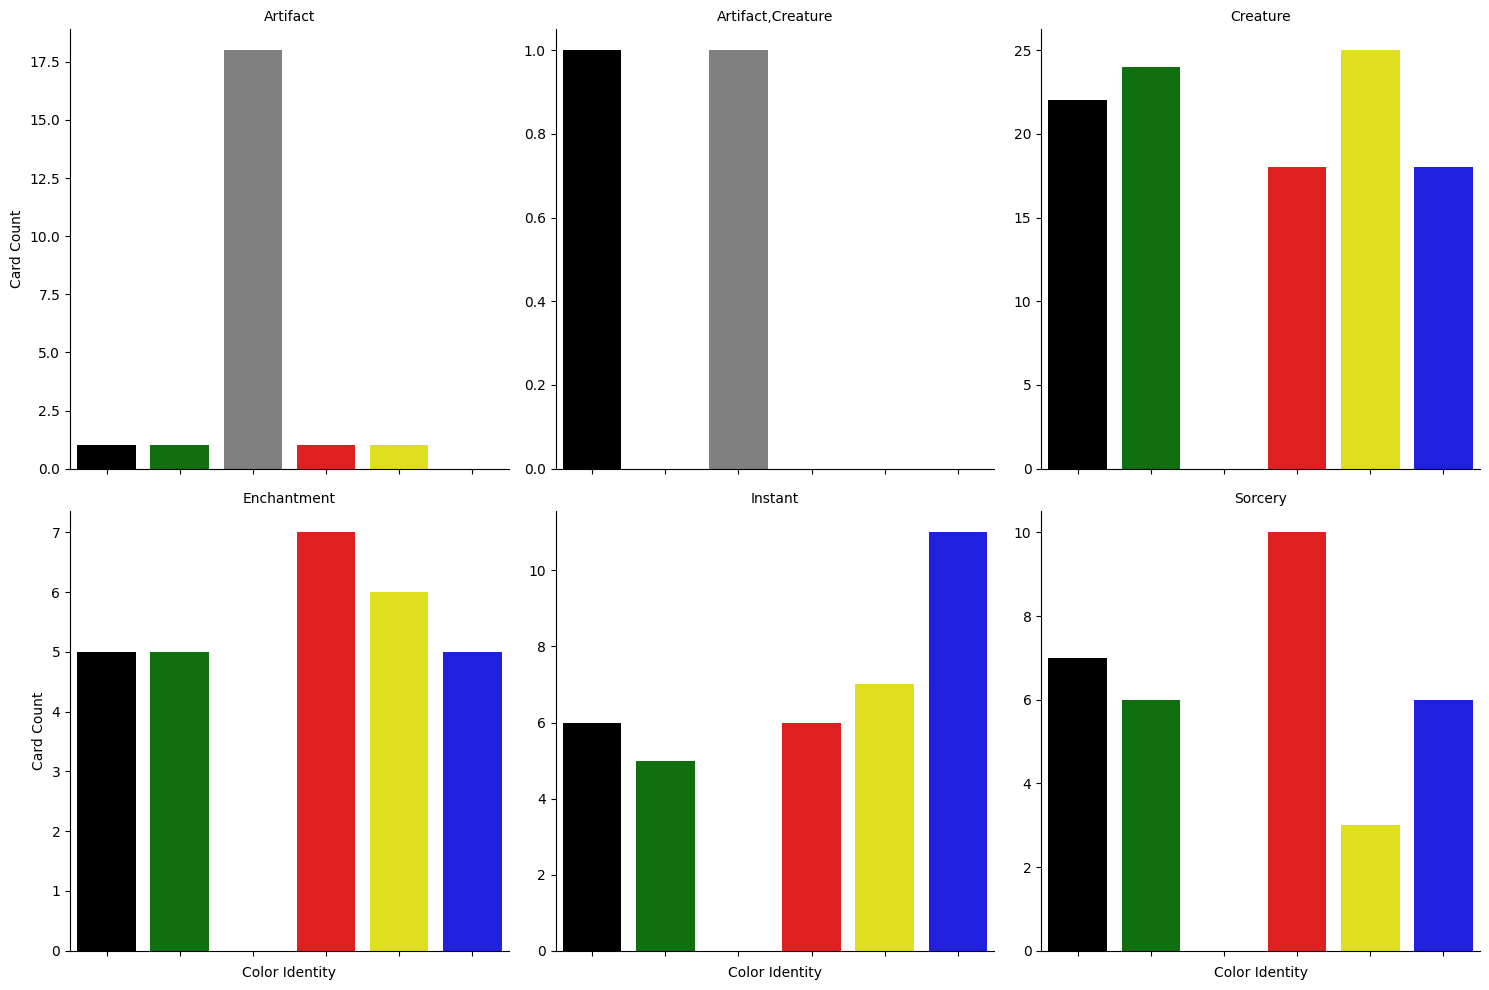

In [199]:
plot_df = formatted_data.copy()
# keep only rows where colorIdentity is a list of length 1
plot_df = plot_df[plot_df['colorIdentity'].apply(lambda x: (isinstance(x, list) and len(x) <= 1) or x == 'None')]
# convert single-element lists to the element (e.g. ['W'] -> 'W')
plot_df['colorIdentity'] = plot_df['colorIdentity'].apply(lambda x: x[0] if isinstance(x, list) else x)


plot_df = plot_df[plot_df['types'].apply(lambda x: isinstance(x, list) and x != ['Land'])]
plot_df['types'] = plot_df['types'].apply(lambda x: ",".join(x) if isinstance(x, list) else str(x))

# group by types and colorIdentity and count occurrences
subtype_counts = plot_df.groupby(['types', 'colorIdentity']).size().reset_index(name='count')

# Define WUBRG None order and custom colors
order = ['W', 'U', 'B', 'R', 'G', 'None']
colors = ['yellow', 'blue', 'black', 'red', 'green', 'gray']
palette = dict(zip(order, colors))

# Facet wrap by 'types'
g = sns.catplot(
    data=subtype_counts,
    x='colorIdentity',
    y='count',
    col='types',            # facet by types
    kind='bar',
    hue='colorIdentity',
    hue_order=order,
    palette=palette,
    col_wrap=3,             # wrap after 4 columns
    sharey=False            # each facet has its own y-scale
)

# Rotate x-ticks and adjust titles
g.set_xticklabels(rotation=45)
g.set_titles("{col_name}")
g.set_axis_labels("Color Identity", "Card Count")

plt.tight_layout()
plt.show()


In [202]:
formatted_data['power'].unique()

array([nan, '3', '5', '2', '4', '1', '*', '6', '7', '8', '0', '9'],
      dtype=object)

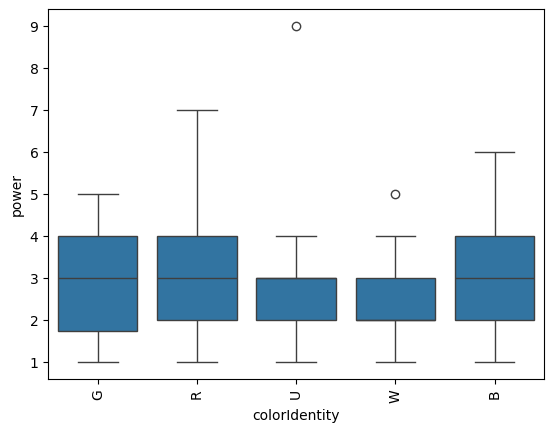

In [207]:
plot_df = formatted_data.copy()
# keep only rows where colorIdentity is a list of length > 1
plot_df = plot_df[plot_df['types'].apply(lambda x: isinstance(x, list) and x == ['Creature'])]
plot_df = plot_df[plot_df['colorIdentity'].apply(lambda x: isinstance(x, list) and len(x) <= 1)]
plot_df = plot_df[plot_df['power'].apply(lambda x: isinstance(x, str) and x.isdigit())]
plot_df['power'] = plot_df['power'].astype(int)

# convert lists to string (e.g. ['G', 'W'] -> 'G,W')
plot_df['colorIdentity'] = plot_df['colorIdentity'].apply(lambda x: ",".join(x) if isinstance(x, list) else str(x))


sns.boxplot(data=plot_df, x='colorIdentity', y='power')
plt.xticks(rotation = 90)
plt.show()

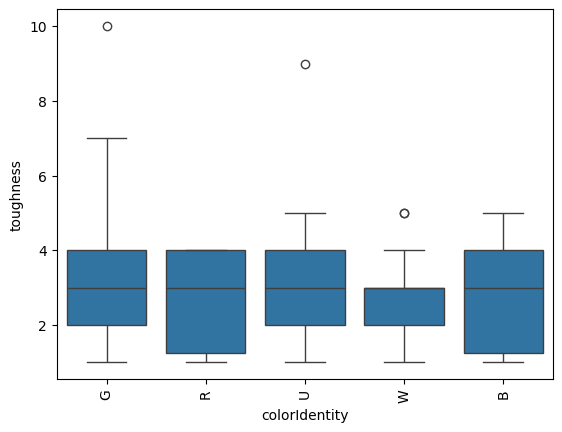

In [208]:
plot_df = formatted_data.copy()
# keep only rows where colorIdentity is a list of length > 1
plot_df = plot_df[plot_df['types'].apply(lambda x: isinstance(x, list) and x == ['Creature'])]
plot_df = plot_df[plot_df['colorIdentity'].apply(lambda x: isinstance(x, list) and len(x) <= 1)]
plot_df = plot_df[plot_df['toughness'].apply(lambda x: isinstance(x, str) and x.isdigit())]
plot_df['toughness'] = plot_df['toughness'].astype(int)

# convert lists to string (e.g. ['G', 'W'] -> 'G,W')
plot_df['colorIdentity'] = plot_df['colorIdentity'].apply(lambda x: ",".join(x) if isinstance(x, list) else str(x))


sns.boxplot(data=plot_df, x='colorIdentity', y='toughness')
plt.xticks(rotation = 90)
plt.show()

In [172]:
formatted_data.head()

,number,name,mana_generic,mana_colored,cmc,colors,colorIdentity,types,supertypes,subtypes,rarity,set,setName,power,toughness,multiverseid,id
237,236,"Andúril, Flame of the West",3,[None],3.0,NaN,None,[Artifact],[Legendary],[Equipment],Mythic,LTR,The Lord of the Rings: Tales of Middle-earth,NaN,NaN,617066,548d68d4-152f-5994-bb8c-2287aba8637c
289,287,"Aragorn and Arwen, Wed",4,"[G, W]",6.0,"[G, W]","[G, W]",[Creature],[Legendary],"[Human, Elf, Noble]",Mythic,LTR,The Lord of the Rings: Tales of Middle-earth,3,6,620182,66208885-03b9-5005-85a9-00bcc3ef3515
192,191,"Aragorn, Company Leader",1,"[G, W]",3.0,"[G, W]","[G, W]",[Creature],[Legendary],"[Human, Ranger]",Rare,LTR,The Lord of the Rings: Tales of Middle-earth,3,3,617021,7774f19e-1737-59b3-8e6a-d50d0ecf21ba
193,192,"Aragorn, the Uniter",0,"[R, G, W, U]",4.0,"[G, R, U, W]","[G, R, U, W]",[Creature],[Legendary],"[Human, Noble]",Mythic,LTR,The Lord of the Rings: Tales of Middle-earth,5,5,617022,3ad5be8a-e07b-5079-b5cf-065b21d60fe0
195,194,Arwen Undómiel,0,"[G, U]",2.0,"[G, U]","[G, U]",[Creature],[Legendary],"[Elf, Noble]",Uncommon,LTR,The Lord of the Rings: Tales of Middle-earth,2,2,617024,6e2654e0-b23e-5487-a3a8-1ee2cd746b93
